In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [2]:
RAW_DATA = pd.read_csv("GoSales.csv", header=0, encoding='latin-1')

Historical customer data for a fictional outdoor equipment store used in Watson Studio tutorials train the machine learning models. The sample data is structured in rows and columns, and saved in a .csv file.

Feature columns

Feature columns are columns that contain the attributes on which the machine learning model will base predictions. In this historical data, there are four feature columns:

GENDER: Customer gender

AGE: Customer age

MARITAL_STATUS: "Married", "Single", or "Unspecified"

PROFESSION: General category of the customer's profession, such "Hospitality" or "Sales", or simply "Other"

Label columns

Label columns are columns that contain historical outcomes that the models will be trained predict. In this historical data, there are three label columns:

IS_TENT: Whether or not the customer bought a tent

PRODUCT_LINE: The product category in which the customer has been most interested

PURCHASE_AMOUNT: The average amount of money the customer has spent on each visit to the store


Link: https://dataplatform.cloud.ibm.com/exchange/public/entr/view/aa07a773f71cf1172a349f33e2028e4e



In [3]:
RAW_DATA.head()

,GENDER,AGE,MARITAL_STATUS,PROFESSION,IS_TENT,PRODUCT_LINE,PURCHASE_AMOUNT
0,M,27,Single,Professional,True,Camping Equipment,144.78
1,F,39,Married,Other,False,Outdoor Protection,144.83
2,F,39,Married,Other,False,Outdoor Protection,137.37
3,F,56,Unspecified,Hospitality,False,Personal Accessories,92.61
4,M,45,Married,Retired,False,Golf Equipment,119.04


In [4]:
RAW_DATA.shape

(60252, 7)

In [5]:
describe_data = pd.concat([RAW_DATA.nunique(), RAW_DATA.dtypes, RAW_DATA.isna().any(),
                               RAW_DATA.describe().loc[['mean','std', 'min', '25%', '50%' ,'75%', 'max']].T],
                              axis=1, sort=False, keys=['Unique Count', 'dType', 'with Null', 'Describe'])
describe_data

Unique Count    dType with Null    Describe                   \
                           0        1         2        mean        std   min   
GENDER                     2   object     False         NaN        NaN   NaN   
AGE                       53    int64     False   34.187479  10.105477  17.0   
MARITAL_STATUS             3   object     False         NaN        NaN   NaN   
PROFESSION                 9   object     False         NaN        NaN   NaN   
IS_TENT                    2     bool     False         NaN        NaN   NaN   
PRODUCT_LINE               5   object     False         NaN        NaN   NaN   
PURCHASE_AMOUNT        10180  float64     False  131.104340  23.086711  65.0   

                                                
                    25%     50%     75%    max  
GENDER              NaN     NaN     NaN    NaN  
AGE               26.00   33.00   41.00   69.0  
MARITAL_STATUS      NaN     NaN     NaN    NaN  
PROFESSION          NaN     NaN     NaN    NaN  
IS_TENT             NaN     NaN     NaN    NaN  
PRODUCT_LINE        NaN     NaN     NaN    NaN  
PURCHASE_AMOUNT  113.18  132.31  148.12  185.0

# Artificially inject nulls

In [6]:
features = RAW_DATA.columns[0:-1]
target =  RAW_DATA.columns[-1]

In [7]:
from random import seed
from random import random

In [8]:
seed(1)

In [9]:
for col in features:
    null_portion = random()*(0.05)
    print('injecting ', (null_portion)*100,'% nulls in column: ', col)
    null_bool = np.random.rand(RAW_DATA.shape[0],1) > (1 - null_portion)
    RAW_DATA[col] = RAW_DATA[[col]].mask(null_bool)

injecting  0.6718212205620061 % nulls in column:  GENDER
injecting  4.237168684686163 % nulls in column:  AGE
injecting  3.8188730948830707 % nulls in column:  MARITAL_STATUS
injecting  1.2753451286971085 % nulls in column:  PROFESSION
injecting  2.477175435459705 % nulls in column:  IS_TENT
injecting  2.247455323943691 % nulls in column:  PRODUCT_LINE


In [10]:
RAW_DATA.head()

,GENDER,AGE,MARITAL_STATUS,PROFESSION,IS_TENT,PRODUCT_LINE,PURCHASE_AMOUNT
0,M,27.0,Single,Professional,1.0,Camping Equipment,144.78
1,F,39.0,Married,Other,0.0,Outdoor Protection,144.83
2,F,39.0,Married,Other,0.0,Outdoor Protection,137.37
3,F,NaN,Unspecified,Hospitality,0.0,Personal Accessories,92.61
4,M,45.0,Married,Retired,0.0,Golf Equipment,119.04


In [11]:
# print null percentage for all columns
RAW_DATA.isna().sum()/RAW_DATA.shape[0]*100

GENDER             0.680475
AGE                4.220607
MARITAL_STATUS     3.921862
PROFESSION         1.357631
IS_TENT            2.386643
PRODUCT_LINE       2.287061
PURCHASE_AMOUNT    0.000000
dtype: float64

In [12]:
RAW_DATA.to_csv('data/GoSales_nulls.csv')

In [13]:
continious_features = RAW_DATA.columns[(RAW_DATA.dtypes != 'object') & (RAW_DATA.dtypes != 'bool')][0:-1]
continious_features

Index(['AGE', 'IS_TENT'], dtype='object')

In [14]:
continious_features_target = RAW_DATA.columns[(RAW_DATA.dtypes != 'object') & (RAW_DATA.dtypes != 'bool')]
continious_features_target

Index(['AGE', 'IS_TENT', 'PURCHASE_AMOUNT'], dtype='object')

In [15]:
categorical_features = RAW_DATA.columns[(RAW_DATA.dtypes == 'object') | (RAW_DATA.dtypes == 'bool')]
categorical_features

Index(['GENDER', 'MARITAL_STATUS', 'PROFESSION', 'PRODUCT_LINE'], dtype='object')

/opt/miniconda3/envs/jupyterhub/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/miniconda3/envs/jupyterhub/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


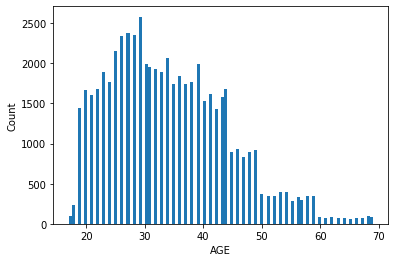

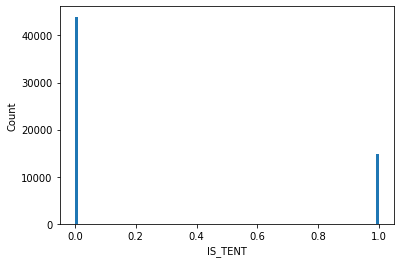

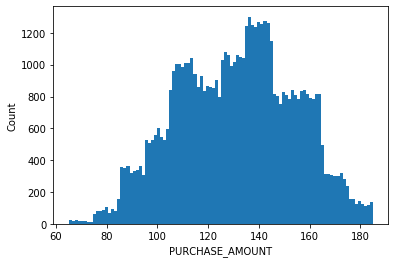

In [16]:
#checking distribution of columns
for i in continious_features_target:
    plt.figure()
    plt.hist(RAW_DATA[i], 100)
    plt.xlabel(i)
    plt.ylabel("Count")

In [17]:
RAW_DATA[categorical_features].describe().T

,count,unique,top,freq
GENDER,59842,2,M,31135
MARITAL_STATUS,57889,3,Married,29572
PROFESSION,59434,9,Other,24164
PRODUCT_LINE,58874,5,Personal Accessories,15263


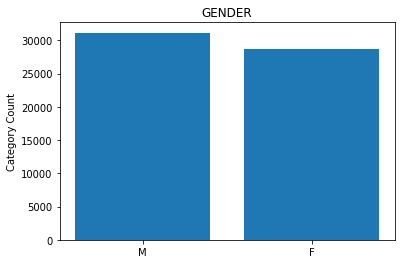

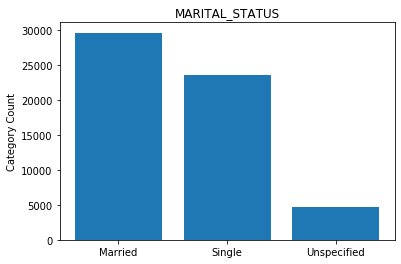

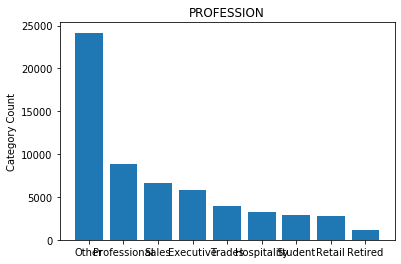

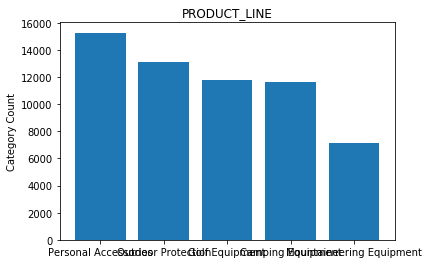

In [18]:
for c in categorical_features:
    
    N = RAW_DATA[c].nunique()
    count = RAW_DATA[c].value_counts().values
    ind = np.arange(N)    # the x locations for the groups
    # width = 0.1       # the width of the bars: can also be len(x) sequence
    
    plt.figure()

    p1 = plt.bar(ind, count)

    plt.ylabel('Category Count')
    plt.title(c)
    plt.xticks(ind, RAW_DATA[c].value_counts().index)

    plt.show()

# Dataset Splitting

In [19]:
X = RAW_DATA[RAW_DATA.columns[0:-1]]
y = RAW_DATA[RAW_DATA.columns[-1]]

In [20]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.20, random_state=42)

# Data encoding

## 1) Categorical columns: 

    a) Null imputation: create a new category

    b) Encoding: encode categories to numberical values (enumerate/random/frequency)

## 2) Numerical columns:

    a) Null imputation: replace null with median(column)

In [21]:
corr=RAW_DATA.corr()
corr.style.background_gradient()

,AGE,IS_TENT,PURCHASE_AMOUNT
AGE,1.000000,-0.380318,0.222915
IS_TENT,-0.380318,1.000000,0.006258
PURCHASE_AMOUNT,0.222915,0.006258,1.000000


# Null Imputation

## Null Imputation for strings

In [22]:
X_train[categorical_features].head()

,GENDER,MARITAL_STATUS,PROFESSION,PRODUCT_LINE
39272,M,Single,Other,Outdoor Protection
34669,F,Single,Other,Outdoor Protection
9128,M,Married,Other,Golf Equipment
56277,F,Married,Sales,Outdoor Protection
58610,F,Married,Other,Outdoor Protection


In [23]:
X_TRAIN_T = X_train.copy()

In [24]:
imp = SimpleImputer(strategy="most_frequent")

In [25]:
X_TRAIN_T[categorical_features] = imp.fit_transform(X_train[categorical_features])

In [26]:
X_TRAIN_T[categorical_features].head()

,GENDER,MARITAL_STATUS,PROFESSION,PRODUCT_LINE
39272,M,Single,Other,Outdoor Protection
34669,F,Single,Other,Outdoor Protection
9128,M,Married,Other,Golf Equipment
56277,F,Married,Sales,Outdoor Protection
58610,F,Married,Other,Outdoor Protection


In [27]:
X_TEST_T = X_test.copy()

In [28]:
X_TEST_T[categorical_features] = imp.transform(X_test[categorical_features])

## Null Imputation for numerical values

In [29]:
X_train[continious_features].isna().any().any()

True

In [30]:
cont_imp = SimpleImputer(strategy="median")

In [31]:
X_TRAIN_T[continious_features] = cont_imp.fit_transform(X_train[continious_features])

In [32]:
X_TRAIN_T[continious_features].isna().any().any()

False

In [33]:
X_TEST_T[continious_features] = cont_imp.transform(X_test[continious_features])

# OneHot Encoding

In [34]:
onehot_enc = preprocessing.OneHotEncoder(sparse = False)

In [35]:
X_TRAIN_OH = onehot_enc.fit_transform(X_TRAIN_T[categorical_features])

In [36]:
# Create a list of  OneHot encoded categories 
OH_COL = []
for col in onehot_enc.categories_:
    OH_COL.extend(col.tolist())

In [37]:
X_TRAIN_OH_DF = pd.DataFrame(X_TRAIN_OH, columns = OH_COL)

In [38]:
X_TRAIN_T_OH = pd.concat([X_TRAIN_OH_DF, X_TRAIN_T[continious_features].reset_index(drop=True)], axis=1)

In [39]:
X_TRAIN_T_OH.head()

,F,M,Married,Single,Unspecified,Executive,Hospitality,Other,Professional,Retail,...,Sales,Student,Trades,Camping Equipment,Golf Equipment,Mountaineering Equipment,Outdoor Protection,Personal Accessories,AGE,IS_TENT
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,35.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,35.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,47.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,49.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.0,0.0


In [40]:
X_TRAIN_T_OH.shape

(48201, 21)

In [41]:
X_TEST_OH = onehot_enc.transform(X_TEST_T[categorical_features])

In [42]:
X_TEST_OH_DF = pd.DataFrame(X_TEST_OH, columns = OH_COL)

In [43]:
X_TEST_T_OH = pd.concat([X_TEST_OH_DF, X_TEST_T[continious_features].reset_index(drop=True)], axis=1)

In [44]:
X_TEST_T_OH.head()

,F,M,Married,Single,Unspecified,Executive,Hospitality,Other,Professional,Retail,...,Sales,Student,Trades,Camping Equipment,Golf Equipment,Mountaineering Equipment,Outdoor Protection,Personal Accessories,AGE,IS_TENT
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,35.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25.0,1.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,27.0,1.0


In [45]:
X_TEST_T_OH.shape

(12051, 21)

# MinMax Scale Age

In [46]:
minmax_enc = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)

In [47]:
X_TRAIN_T_OH['AGE'] = minmax_enc.fit_transform(X_TRAIN_T_OH['AGE'].values.reshape(-1,1))

In [48]:
X_TRAIN_T_OH['AGE'].describe()

count    48201.000000
mean         0.330082
std          0.190521
min          0.000000
25%          0.192308
50%          0.307692
75%          0.442308
max          1.000000
Name: AGE, dtype: float64

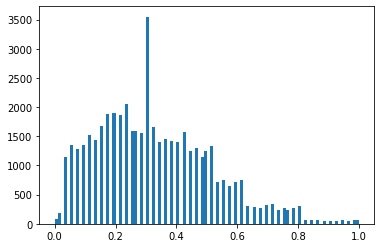

In [49]:
plt.hist(X_TRAIN_T_OH['AGE'], 100)
plt.show()

In [50]:
X_TEST_T_OH['AGE'] = minmax_enc.transform(X_TEST_T_OH['AGE'].values.reshape(-1,1))

# Train a Linear Regression model

In [51]:
y_train.values

array([145.39, 134.56, 126.81, ..., 126.68, 156.38, 110.2 ])

In [52]:
reg = LinearRegression().fit(X_TRAIN_T_OH, y_train)

In [53]:
train_prediction = reg.predict(X_TRAIN_T_OH)

In [54]:
train_RMSE = np.sqrt(mean_squared_error(y_train, train_prediction))
train_RMSE

9.588894454897043

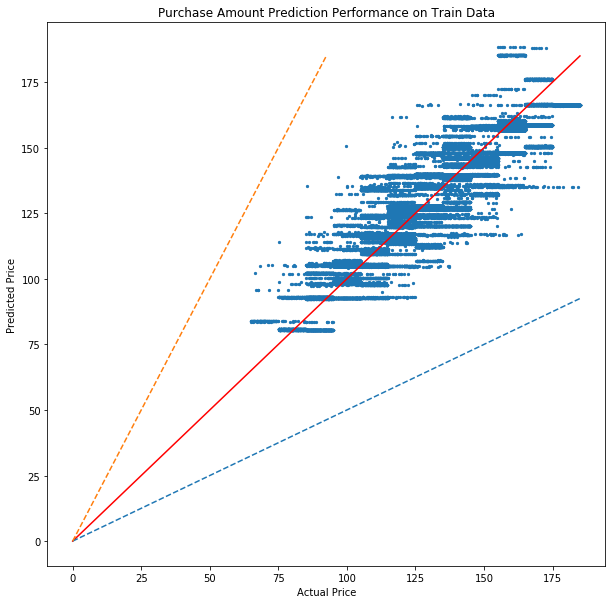

In [55]:
# Model performance on train data
act = y_train
pred = train_prediction
plt.figure(figsize = (10,10))
plt.scatter(act,pred,s=5)
x = np.linspace(0, act.max(), 1000)
y = x
plt.plot(x,y,'k',color = 'r')
y = 0.5*x
plt.plot(x,y,linestyle='dashed')
y = np.linspace(0, act.max(), 1000)
x = 0.5*y
plt.plot(x,y,linestyle='dashed')
plt.title('Purchase Amount Prediction Performance on Train Data')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
# plt.xlim(0,80000)
# plt.ylim(0,80000)
plt.show()

In [56]:
test_prediction = reg.predict(X_TEST_T_OH)

In [57]:
test_RMSE = np.sqrt(mean_squared_error(y_test, test_prediction))
test_RMSE

9.489638792153643

In [58]:
mean_squared_error(y_test, test_prediction)

90.05324440554726

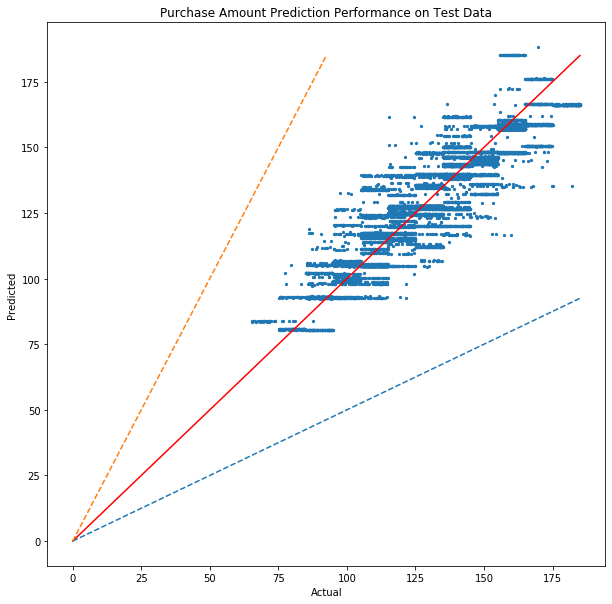

In [59]:
# Model performance on test data
act = y_test
pred = test_prediction
plt.figure(figsize = (10,10))
plt.scatter(act,pred,s=5)
x = np.linspace(0, act.max(), 1000)
y = x
plt.plot(x,y,'k',color = 'r')
y = 0.5*x
plt.plot(x,y,linestyle='dashed')
y = np.linspace(0, act.max(), 1000)
x = 0.5*y
plt.plot(x,y,linestyle='dashed')
plt.title('Purchase Amount Prediction Performance on Test Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
# plt.xlim(0,80000)
# plt.ylim(0,80000)
plt.show()

# Export Model as Joblib File

In [60]:
joblib.dump(reg,'my_model.joblib')

['my_model.joblib']